In [1]:
# Create the environment & make it accessible from jupyter:
# cd workshop/
# python -m venv sutton_venv
# source sutton_venv/bin/activate
# pip install ipykernel
# python -m ipykernel install --user
# pip install pandas matplotlib transformers datasets spacy seqeval torch rapidfuzz 
# python -m spacy download en_core_web_sm

# In VSCODE:
# Select kernel -> download the recommended extensions -> select kernel -> Python Environment -> sutton_venv

---
# Analysing Zoo Reviews with Natural Language Processing (NLP)
---

#### Getting Started with the Notebook

Most of the code in this notebook is already written for you. Your job is to run the cells and explore the outputs to understand what's happening. You're free to explore and change parameters and see how the results change!


To run any code cell:

- Click inside the cell

- Press `Shift + Enter` (or use the ▶ button at the top of the notebook)

Make sure to run the cells **in order**, from top to bottom.

---
## Introduction
---

Imagine you work at **Edinburgh Zoo** and your job is to help improve the experience for future visitors. Every day, people write online reviews describing what they liked (or didn't like) about their visit. These reviews contain valuable feedback — but they are written in free-form text and can quickly become overwhelming.

If you had only ten reviews, you might be able to read them all yourself and spot patterns. But what if you had hundreds or thousands?

That's where **Natural Language Processing (NLP)** comes in. NLP is a field of Artificial Intelligence that allows us to extract structure and meaning from human language. By combining a set of smart tools, we can automatically process visitor reviews, identify which animals are mentioned, understand the emotions expressed about them, and summarise the main opinions — all without having to read every sentence ourselves.

#### What We're Trying to Do

We want to answer questions such as:

- *Which animals do visitors **mention most**?*

- *What do people **like** or **dislike** about different animals?*

- *Are there any consistent **complaints** or **highlights**?*

- *Can we produce a **summary for each animal** based on real visitor feedback?*

To do this, we will go step by step from raw reviews to structured summaries.

#### Why Not Just Ask ChatGPT?

You might wonder: *why not simply copy all the reviews into a tool like ChatGPT and ask it to summarise them?*

There are two key reasons:

1. **Scale and Structure:** LLMs work best when given well-structured, focused inputs. Feeding in an entire review dataset — thousands of unrelated sentences — without any filtering or organisation would produce vague or unreliable outputs.

2. **Transparency and Control:** By splitting the task into parts (e.g. identifying animals, measuring sentiment, visualising results), we can understand what is happening at each stage. This not only builds trust in the results but also gives us flexibility to tune or troubleshoot specific steps.

In this notebook, we will build a simple pipeline using Python and some powerful pre-trained models to:

1. **Clean** and **prepare** the review data

2. **Find animals** in sentences

3. Identify **to what animal in the zoo** the sentence refers to 

4. Run **sentiment analysis** to gauge emotions

5. Create plots to **visualise** sentiment per animal

6. Generate short, readable **summaries** for each animal using a language model

#### Tools We'll Use

We'll be using the following tools and libraries:

| Tool / Library                          | Purpose                                                                 |
|----------------------------------------|-------------------------------------------------------------------------|
| `pandas`                               | For organising and analysing tabular data                              |
| `transformers` (Hugging Face)          | For using pre-trained models (NER, sentiment analysis, and LLMs)       |
| `spacy`                                | For splitting paragraphs into individual sentences                     |
| `matplotlib`                           | For plotting visualisations                                            |
| `re` (regular expressions)             | Temporary method for detecting animal mentions in text (to be replaced by NER) |
| A local large language model (Mistral-7B) | To generate natural-language summaries based on grouped reviews      |

---
## Step 1: Load and Explore the Review Data
---

We'll be using real visitor reviews collected from an online platform (TripAdvisor), where people share their experiences at Edinburgh Zoo.

To save time, the data has already been collected and lightly cleaned. It's stored in a CSV file called `edinburgh-zoo-reviews-1990.csv`. Each row contains:
- A **title** (short summary),
- And a **full review text** (the visitor's main comments).

Run the following code cell to load the data and take a look at a few example reviews.

In [2]:
# Import the pandas library for data handling
import pandas as pd

# Load the review data from the CSV file
df = pd.read_csv("edinburgh-zoo-reviews-1990.csv")

# Change the maximum column width to display full text
pd.set_option('display.max_colwidth', None)

# Display the first 5 rows of the dataset
df.head(5)

,title,review,date
0,Family Day Out At The Zoo,"Had an amazing time here with my little girl and her gran on a sunny day in June.Variety of animals the zoo has is incredible, plenty of places to eat and drink, great selection of play parks for kids, and the staff do an amazing job of keeping the entire zoo immaculate.We all had a magical day and would highly recommend it for a day out with the family.It's a little bit hilly (especially on way up to see lions and tigers) but well worth the climb uphill to see such beautiful animals.The animal talks were highly engaging and would also highly recommend attending these when visiting.Keep up the brilliant work RZSS.",28 June 2025
1,An excellent day out,We visited using the season ticket from our local zoo. From arrival we were made very welcome. Staff took time out to talk to us and tell us about the animals. We loved the large enclosures that the animals had to roam in and had great views of many during the day. Thank you everyone for a great day!,25 June 2025
2,Our favourite place for our days off,We’re members and love the zoo.So many different animals too see and easy to get to by the 26 or 31 bus from the Center.It is a challenging zoo as it’s all on hill so be prepared to get your hike on but it’s all worth it.Staff are great and always happy to helpWorth a visit we almost go every other month,20 June 2025
3,Youth club day out,"Brilliant day out with the Youth Club at the Zoo, we travelled all the way up from County Durham and the zoo staff couldnt have been more helpful from initial contact to collecting the tickets on the day. The zoo was clean and tidy and the group loved it with the penguins being a firm favourite. We even took advantage of the lunch voucher system and the visit triggered some additional workshops following the visit.",14 June 2025
4,Best zoo,"This was without a doubt one of the best zoo visits we've ever had (helped by the fact we stayed at the Holiday Inn on sight and were offered discounted tickets after 14:00, so therefore the crowds had also dispersed) Despite the layout being steep, the views over Edinburgh were superb once at the top, everything was well laid out and easy to find. Just wish we'd had longer, but I'm sure we will return!",12 June 2025


<div style="
  border-left: 5px solid #4caf50;
  background: #f6ffed;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>Try this:</strong> Change the number inside <code>head(5)</code> to see more reviews!
</div>

---
## Step 2: Prepare the Review Text
---

Before we can analyse the reviews, we need to **prepare the text**. Online reviews - like those from TripAdvisor - are often informal. That means they might contain:

- Long paragraphs with multiple ideas  
- Inconsistent punctuation or formatting  
- Occasional typos or grammar mistakes  

All of this can make it harder for our analysis to be accurate or meaningful. So before we go further, we'll do one key thing:

- **Split each review into individual sentences** — to break down complex reviews into smaller, more focused pieces of text.

<!-- 💡 Why Split Reviews Into Sentences? -->
<div style="
  border-left: 5px solid #ffc107;
  background: #fff8e1;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong> Why Split Reviews Into Sentences?</strong><br>
  A single review can mention several animals — and express very different emotions about each one. For example:
  <br><br>
  <em>“The penguins were adorable! But the food was overpriced. They charged us £15 for two dry sandwiches. It's outrageous!”</em>
  <br><br>
  If we analyse the whole review at once, we might detect the word <code>penguins</code> and assume the reviewer had a bad experience with them. That would be misleading.
  <br><br>
  To avoid this, we will analyse <strong>sentiment at the sentence level</strong>, so we can link specific opinions to specific animals more reliably.
</div>

<!-- ⚙️ How Does Sentence Splitting Work? -->
<div style="
  border-left: 5px solid #007acc;
  background: #f0f8ff;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong> How Does Sentence Splitting Work?</strong><br>
  We'll use a pre-trained model from the <code>spaCy</code> NLP library. It’s been trained on large collections of real-world English - including books, news articles, and websites - to learn where sentences begin and end.
  <br><br>
  These models are fast, reliable, and much easier to use than writing custom rules by hand. Curious? You can explore spaCy's models here:  
  <a href="https://spacy.io/models/en" target="_blank">https://spacy.io/models/en</a>
</div>

<!-- 📝 What About Spelling or Grammar Mistakes? -->
<div style="
  border-left: 5px solid #4caf50;
  background: #f6ffed;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong> What About Spelling or Grammar Mistakes?</strong><br>
  Typos and grammar issues are common in online reviews. In a more advanced project, we might fix these first to improve the accuracy of tasks like sentence splitting or sentiment analysis.
  <br><br>
  But in this notebook, the reviews are relatively clean - and to keep things simple, we'll skip this step for now.
</div>


#### Let's Try It Out

Let's try applying the `spaCy` model to split one full review into individual sentences.

In [3]:
# Display a full review from the dataset
print(df["review"].iloc[5])

Loved seeing all the different animals especially the penguins and giraffes! Great choice of gifts in gift shop. Staff all friendly, approachable and helpful. Despite the rain it was an enjoyable experience!


You should see something like:

> Loved seeing all the different animals especially the penguins and giraffes! Great choice of gifts in gift shop. Staff all friendly, approachable and helpful. Despite the rain it was an enjoyable experience!

Now let's split this into cleaner, shorter sentences:

In [4]:
import spacy

# Load the pre-trained English NLP model from spaCy
nlp = spacy.load("en_core_web_sm")

# Get the review text and clean it slightly
raw_text = df["review"].iloc[5]
cleaned_text = raw_text.replace("\n", " ").strip()

# Apply the NLP model to split into sentences
doc = nlp(cleaned_text)
sentences = [sent.text.strip() for sent in doc.sents]

# Display each sentence one by one
for i, sentence in enumerate(sentences, 1):
    print(f"{i}. {sentence}")

1. Loved seeing all the different animals especially the penguins and giraffes!
2. Great choice of gifts in gift shop.
3. Staff all friendly, approachable and helpful.
4. Despite the rain it was an enjoyable experience!


The output should look like:

> 1. Loved seeing all the different animals especially the penguins and giraffes!
> 2. Great choice of gifts in gift shop.
> 3. Staff all friendly, approachable and helpful.
> 4. Despite the rain it was an enjoyable experience!

#### Why This Is Helpful

This result shows how a single paragraph can be neatly split into focused thoughts:

- **Sentence 1** talks about *animals* (penguins and giraffes)

- **Sentence 2** is about the *gift shop*

- **Sentence 3** focuses on the *staff*

- **Sentence 4** reflects on the *overall experience*


By working at the sentence level, we can now link specific opinions to specific topics — like *individual animals* — instead of just tagging a vague overall mood.

#### Now Let's Do This for Every Review

We've now seen how to split a single review into sentences. Next, we'll apply this to the entire dataset.

This will give us:

- One sentence per row

- Clearer, more focused units of analysis

- A better foundation for tasks like animal detection and sentiment analysis

Let's build the full sentence-level dataset now.

In [5]:
# Create an empty list to hold the results
split_sentences = []

# Loop through each review in the dataset
for idx, review in df["review"].items():
    if isinstance(review, str): # Make sure it's a string
        # Clean up formatting
        cleaned = review.replace("\n", " ").strip()
        
        # Apply the NLP model
        doc = nlp(cleaned)
        
        # Extract individual sentences
        for sentence in doc.sents:
            split_sentences.append({
                "Review Index": idx,
                "Sentence": sentence.text.strip()
            })

# Create a new DataFrame with one sentence per row
sentences_df = pd.DataFrame(split_sentences)

# Show a preview of the result
sentences_df.head(20)

,Review Index,Sentence
0,0,Had an amazing time here with my little girl and her gran on a sunny day in June.
1,0,"Variety of animals the zoo has is incredible, plenty of places to eat and drink, great selection of play parks for kids, and the staff do an amazing job of keeping the entire zoo immaculate."
2,0,We all had a magical day and would highly recommend it for a day out with the family.
3,0,It's a little bit hilly (especially on way up to see lions and tigers) but well worth the climb uphill to see such beautiful animals.
4,0,The animal talks were highly engaging and would also highly recommend attending these when visiting.
5,0,Keep up the brilliant work RZSS.
6,1,We visited using the season ticket from our local zoo.
7,1,From arrival we were made very welcome.
8,1,Staff took time out to talk to us and tell us about the animals.
9,1,We loved the large enclosures that the animals had to roam in and had great views of many during the day.


---
## Step 3: Find the Animals!
---

Now that each review is split into individual sentences, we can look more closely at **what** people are talking about.

In this step, we'll use a technique called **Named Entity Recognition (NER)** to detect specific animals mentioned in the text — like *penguins*, *giraffes*, or *tigers*.

NER is part of a field called **Natural Language Processing (NLP)**. It's used to automatically identify and label important things in text, such as:

- People's names (e.g. *Jane Goodall*)
- Locations (e.g. *Edinburgh Zoo*)
- Organisations (e.g. *RZSS*)
- Products, dates, times…  
...and yes, even **animals**.

<div style="
  border-left: 5px solid #007acc;
  background: #f0f8ff;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong> What's the Point?</strong><br>
  By tagging animal mentions in each sentence, we'll be able to:
  <ul style="margin-top: 0.5em; margin-bottom: 0;">
    <li>Count which animals are most talked about</li>
    <li>Link animals to specific opinions and emotions</li>
    <li>Create fun visualisations of animal mentions</li>
  </ul>
  <p style="margin-top: 0.75em; margin-bottom: 0;">
    This helps us understand how visitors feel about different parts of the zoo.
  </p>
</div>

#### Coming Up Next…

We'll load a pre-trained NER model (like the one from <code>spaCy</code>), run it on our sentence-level DataFrame, and extract any animals it can find.

Later, we'll combine this with **sentiment analysis** to detect *how* people feel about each animal.  

Let's get ready to go animal spotting!

The first step is to load the pretrained model and the tokenizer used:

In [6]:
# LOAD THE MODEL AND THE TOKENIZER
from transformers import AutoTokenizer, AutoModelForTokenClassification

LOAD_MODEL_PATH = "animal-ner-model"

tokenizer = AutoTokenizer.from_pretrained(LOAD_MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(LOAD_MODEL_PATH)

/home/cdt_wsl/git/sutton_workshop/sutton_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now, we have to prepare the sentences in our dataset to be inputted into the model. But we can't do that directly. The model doesn't understand text. We must **tokenize them**: separate them into sub-words. For that, we use the function `tokenize_sentences`. Let's see how it works for for an example sentence:

In [39]:
# Write a sentence to tokenize
# Change this sentence to whatever you want!
example_sent = "We loved to see the tigers and penguins at the zoo."

# Tokenize the example sentence
def tokenize_sentences(sentences):
    """
    Tokenizes a list of sentences and returns the encodings.
    """
    return tokenizer(
        sentences,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
        return_offsets_mapping=True
    )

encodings = tokenize_sentences([example_sent])

# Get the information we need out of the encodings
input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
offset_mappings = encodings["offset_mapping"]

# Use the encodings information to annotate the sentence
import torch
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# Use the function "argmax" to extract the predictions from the model's output
predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to labels
labels = [model.config.id2label[pred_id.item()] for pred_id in predictions[0]]

# Show the results
print("Original sentence:", example_sent)

print("Result:")
pd.DataFrame({
    "Token":            tokenizer.convert_ids_to_tokens(encodings["input_ids"][0]),
    "Input IDs":        input_ids[0].tolist(),
    "Offset Mapping":   offset_mappings[0].tolist(),
    "Predictions":      predictions[0].tolist(),
    "Predicted Label":  labels
}).set_index("Token").transpose()

Original sentence: We loved to see the tigers and penguins at the zoo.
Result:


Token,[CLS],We,loved,to,see,the,tiger,##s,and,pen,##guin,##s,at,the,zoo,.,[SEP]
Input IDs,101,1284,3097,1106,1267,1103,13778,1116,1105,8228,25913,1116,1120,1103,15003,119,102
Offset Mapping,"[0, 0]","[0, 2]","[3, 8]","[9, 11]","[12, 15]","[16, 19]","[20, 25]","[25, 26]","[27, 30]","[31, 34]","[34, 38]","[38, 39]","[40, 42]","[43, 46]","[47, 50]","[50, 51]","[0, 0]"
Predictions,0,0,0,0,0,0,1,2,0,1,2,2,0,0,0,0,0
Predicted Label,O,O,O,O,O,O,B-ANIMAL,I-ANIMAL,O,B-ANIMAL,I-ANIMAL,I-ANIMAL,O,O,O,O,O


Observe that tokenising doesn't exactly correlate with separating into words: "penguins", for example, is tokenized into 3 tokens: "pen", "##guin" and "##s". The "##" indicates that the token is part of the previous sentence.

>**DO IT YOURSELF:** Try out different sentences, or words. See how they tokenize! Most common words will be kept together (the model has seen it so many times). While rarer words will be split into different ones. What word can you come up that will lead to the most tokens?


The next cell contains all the code needed to move from sentences to encodings (as shown above), to get predictions from the model using the encod get the animal entities (if present) from these entities. Running the predictions for all the sentences, in this computer (which does not have access to a GPU), would be very slow. To speed up the process, we'll only run it in 10% of the data, and then, we'll load the dataset where the annotations have already been done for you!

In [9]:
# ANNOTATE A SUBSET OF THE SENTENCES
# LOAD THE FULL ANNOTATED DATASET

# USE MODEL TO ANNOTATE THE REVIEWS
from tqdm import tqdm # Use to create a progression bar
import torch

# === Helper functions
def flush_entity(entities, entity_token_idxs):
    """
    Save the entity into the entities  list
    """
    # Get character-level start and end positions of the whole entity
    span_offsets = [offsets[i].tolist() for i in entity_token_idxs]
    start_char = span_offsets[0][0]
    end_char = span_offsets[-1][1]

    # Save the entity in the "entities" list for that sentence as a tuple (animal, start_char, end_char)
    entities.append((sentence[start_char:end_char].strip().lower(), start_char, end_char))
    # Reset the tracker for the next entity
    entity_token_idxs = []
    
    return entities, entity_token_idxs

def backtrack_to_word_start(input_ids_sent, tok_idx, entity_token_idxs):
    """Backtracks from a subword token to the start of the full word."""

    # If the initial token is a subword, search for the start of the word
    token_text = tokenizer.convert_ids_to_tokens([input_ids_sent[tok_idx]])[0]
    if token_text.startswith("##"):
        
        # Recursively move backwards to get to the start of the word
        prev_idx = tok_idx - 1

        while prev_idx >= 0:
            # Insert the token into the entity_token_idxs
            entity_token_idxs.insert(0, prev_idx)
            
            # Check if the token contains ##. If so, move backwards to the previous token. Else, break the loop
            token_text = tokenizer.convert_ids_to_tokens([input_ids_sent[prev_idx]])[0]
            if token_text.startswith("##"):
                prev_idx -= 1
            else:
                break

    return entity_token_idxs

def forwardtrack_to_word_end(input_ids_sent, tok_idx, entity_token_idxs):
    """Looks ahead to include remaining subword tokens (e.g. ##e from giraffe)."""

    # Check if the next token is still part of the entity, and if so, recursively add
    next_idx = entity_token_idxs[-1] + 1
    token_text = tokenizer.convert_ids_to_tokens([input_ids_sent[next_idx]])[0]

    # While loop to ensure we don't go past the end of the sentence
    while next_idx < len(input_ids_sent):
        if token_text.startswith("##"):
            # Token is part of the entity. Add, and check next token
            entity_token_idxs.append(next_idx)
            next_idx += 1
        else:
            # Start of new word. Break the loop
            break

    return entity_token_idxs

def get_entities_from_predictions(preds, input_ids_sent, offsets):
    """
    Extracts entities from the model predictions and input IDs.
    """

    # Setup tracking variables
    entity_token_idxs = []  # Holds the indexes of the tokens that are currently forming an entity.
    entities = []           # will store all extracted animal mentions in the sentence.
    label = "O"             # Initialises label

    # Loop over each token
    for tok_idx, pred_id in enumerate(preds):
        
        # Save the label of the previous token before finding the label of this token
        previous_label = label 

        # Convert prediction to label and get character offsets
        label = model.config.id2label[pred_id.item()]
        start, end = offsets[tok_idx].tolist()

        # Skip special tokens ([CLS], [SEP], padding)
        # Determined by span_start = span_end (does not occupy space in the sentence)
        if start == end == 0: 
            continue

        # Skip tokens not predicted as an entity
        if label == "O":
            continue

        # Fix invalid I-ANIMAL without preceding B-ANIMAL
        if (label == "I-ANIMAL") and (previous_label not in {"B-ANIMAL", "I-ANIMAL"}):
            label = "B-ANIMAL"

        # Save the previous entity (if exists, and current token not part of an entity)
        if (entity_token_idxs != []) and (label != "I-ANIMAL") :

            # Fix cases where entity doesn't reach the end of the word (e.g. "giraff").
            entity_token_idxs = forwardtrack_to_word_end(input_ids_sent, tok_idx, entity_token_idxs)

            # Save to entities and reset entity_token_idxs tracker
            entities, entity_token_idxs = flush_entity(entities, entity_token_idxs)

        if label == "B-ANIMAL":
            # Add the token id into the entity_token_idxs
            entity_token_idxs = [tok_idx]

            # If the initial token is a subword, search for the start of the word
            entity_token_idxs = backtrack_to_word_start(input_ids_sent, tok_idx, entity_token_idxs)
                            
        elif label == "I-ANIMAL":
            entity_token_idxs.append(tok_idx)
    
    # Final flush at end of sentence
    if entity_token_idxs:
        entities, entity_token_idxs = flush_entity(entities, entity_token_idxs)
    
    # Divide entities between spans and entities
    animals = [ent[0] for ent in entities] # ent[0] is the animal name
    spans = [tuple(ent[1:3]) for ent in entities] # ent[1:3] is the start_char and end_char

    # Return the entities found in the sentence
    return animals, spans

# === Extract the animals!

# "batch size" refers to how many sentences we process at once.
# Processing more sentences at once is faster, but requires more memory.
batch_size = 16

# Initialise a list to store the annotated sentences
NER_animals = []

# Convert the dataframe sentences into a list for easy handling
all_sentences = list(sentences_df["Sentence"])

# Only show for a subset of the sentences (otherwise, it will take 5 minutes!)
all_sentences = all_sentences[:512]

# Iterate over each batch (of 16 sentences) to find the animals. Tqdm is used to show a progress bar
for i in tqdm(range(0, len(all_sentences), batch_size), desc="Finding animals in text"):
    sentences = all_sentences[i:i+batch_size]

    # Tokenize all sentences in the batch
    encodings = tokenize_sentences(sentences)

    # Get the information we need out of the encodings
    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]
    offset_mappings = encodings["offset_mapping"]

    # Use the model to annotate the sentences
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Use the function "argmax" to extract the predictions from the model's output
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Iterate over each sentence in the batch
    for sent_idx, sentence in enumerate(sentences):
        # Use "sent_idx" to extract the relevant information for this sentence
        preds = predictions[sent_idx]           # predicted labels (as IDs) for each token
        input_ids_sent = input_ids[sent_idx]    # the token IDs for the sentence (what was passed into the model).
        offsets = offset_mappings[sent_idx]     # for each token, this tells use where the original string of the token came from

        # Use the function "get entities from predictions" to extract the animals present in the sentence and their spans
        animals, spans = get_entities_from_predictions(preds, input_ids_sent, offsets)

        # Append the results to the NER_animals list
        NER_animals.append({
            "review_sentence": sentence,
            "animals": animals,
            "spans":   spans
        })

# Convert into dataframe for easier handling
animal_sentences_df = pd.DataFrame(NER_animals)

# animal_sentences_df now only has a subset of the sentences, as otherwise it would have taken too long. 
# Load the dataframe with all the sentences
animal_sentences_df = pd.read_json("NER_animals.json")

# Filter out all sentences where no animals were detected (where inst["animals"] is empty)
animal_sentences_df = animal_sentences_df[animal_sentences_df["animals"].apply(lambda x: len(x) > 0)]
animal_sentences_df.head()

# Show 3 examples:
animal_sentences_df.head(3)

Finding animals in text:   0%|          | 0/822 [00:00<?, ?it/s]

Finding animals in text:   9%|▊         | 70/822 [03:36<38:49,  3.10s/it]  


KeyboardInterrupt: 

Now we have the annotated dataset. Let's see how many different instances it has found:

In [42]:
# Count number of times each animal was mentioned (including duplicates per sentence)
animals_mention_counts = (
    animal_sentences_df.explode("animals")["animals"]
    .value_counts()
    .sort_values(ascending=False)
)
# How many different animals we get?
print(f"Number of different animals mentioned: {len(animals_mention_counts)}")

# Show the top 10 most mentioned animals
animals_mention_counts.head(10)

Number of different animals mentioned: 96


animals
penguins    33
penguin     22
giraffes    22
sloths      12
rhino       10
lion        10
monkeys      9
tiger        9
sloth        8
lions        8
Name: count, dtype: int64

---
## Step 4: Normalise the animal names!
---

The model has found way more types of animals than animals present in the zoo! But that's not due to people mentioning a lot of animals: is because they mention them using a lot of different names!

Let's see, for example, in how many different ways do people talk about penguins:

In [44]:
# Select the string to search for
string_to_search = "peng"

# Filter the animals_mention_counts to find sentences containing the string
filtered_animals = animals_mention_counts[animals_mention_counts.index.str.contains(string_to_search, case=False)]

filtered_animals

animals
penguins            33
penguin             22
emperor penguins     1
Name: count, dtype: int64

>[!tip Try it out!]
>Change the string to search for, to see how other animals are named. You can try "cat" or "giraf". 
>Be aware that what this does is a pure string match. For example, "giraffe" won't match if someone has misspelled it as "girafe".


People mention "penguins" in too many ways, and we need to find a way to tell the model that all those sentences refer to the same zoo animal: the penguins! For that, we need to **normalise** it to one of the animals in the zoo.


#### Our Custom Animal List

We've created a list of all animals currently found at **Edinburgh Zoo**, along with common ways visitors might refer to them.  
This includes:

- Official names (e.g. `"Northern rockhopper penguin"`)
- Simple versions (e.g. `"penguin"`, `"giraffe"`, `"tiger"`)
- Nicknames and aliases (e.g. `"bearcat"` for a *binturong*, `"duck"` for a *pochard*)

The full list is shown in the cell below:

In [45]:
# ALIAS DICTIONARY
edinburgh_zoo_animal_aliases = {
    "Alpaca": ["alpaca"],
    "Asian small clawed otter": ["asian otter", "small clawed otter", "otter"],
    "Asiatic lion": ["asiatic lion", "lion"],
    "Baer's pochard": ["pochard", "baer's pochard", "duck"],
    "Bagot goat": ["bagot goat", "goat"],
    "Banteng": ["banteng", "wild cattle"],
    "Binturong": ["binturong", "bearcat"],
    "Blue poison dart frog": ["blue poison dart frog", "poison dart frog", "dart frog", "frog"],
    "Brown capuchin": ["brown capuchin", "capuchin monkey", "capuchin"],
    "Buff-cheeked gibbon": ["buff-cheeked gibbon", "gibbon"],
    "Cape porcupine": ["cape porcupine", "porcupine"],
    "Capybara": ["capybara", "capy", "capys"],
    "Cheetah": ["cheetah"],
    "Chilean flamingo": ["chilean flamingo", "flamingo"],
    "Chilean rose tarantula": ["chilean rose tarantula", "tarantula", "spider"],
    "Chimpanzee": ["chimpanzee", "chimp", "chimps"],
    "Chinese goral": ["chinese goral", "goral"],
    "Common squirrel monkey": ["common squirrel monkey", "squirrel monkey"],
    "Coppery titi monkey": ["coppery titi monkey", "titi monkey"],
    "Cotton-top tamarin": ["cotton-top tamarin", "tamarin"],
    "Crowned lemur": ["crowned lemur", "lemur"],
    "Drill": ["drill"],
    "East African crowned crane": ["east african crowned crane", "crowned crane", "crane"],
    "Eastern white pelican": ["eastern white pelican", "pelican"],
    "Gelada baboon": ["gelada", "gelada baboon", "baboon"],
    "Gentoo penguin": ["gentoo penguin", "penguin"],
    "Giant African land snail": ["giant african land snail", "land snail", "snail"],
    "Giant anteater": ["giant anteater", "anteater"],
    "Goeldi's monkey": ["goeldi's monkey", "goeldi monkey"],
    "Greater one-horned rhinoceros": ["greater one-horned rhinoceros", "rhinoceros", "rhino"],
    "Grevy's zebra": ["grevy's zebra", "zebra"],
    "Ground cuscus": ["ground cuscus", "cuscus"],
    "Japanese macaque": ["japanese macaque", "macaque"],
    "King penguin": ["king penguin", "penguin"],
    "Kirk's dik-dik": ["kirk's dik-dik", "dik-dik"],
    "L'Hoest's monkey": ["lhoest's monkey"],
    "Land hermit crab": ["land hermit crab", "hermit crab", "crab"],
    "Large hairy armadillo": ["large hairy armadillo", "armadillo"],
    "Leopard tortoise": ["leopard tortoise", "tortoise"],
    "Linne's two-toed sloth": ["linne's two-toed sloth", "two-toed sloth", "sloth"],
    "Lowland nyala": ["lowland nyala", "nyala"],
    "Malayan sun bear": ["malayan sun bear", "sun bear", "bear"],
    "Meerkat": ["meerkat"],
    "Northern Luzon giant cloud rat": ["northern luzon giant cloud rat", "cloud rat", "rat"],
    "Northern rockhopper penguin": ["northern rockhopper penguin", "rockhopper penguin", "penguin"],
    "Nubian giraffe": ["nubian giraffe", "giraffe"],
    "Pallas's cat": ["pallas's cat", "pallas cat"],
    "Pied imperial pigeon": ["pied imperial pigeon", "pigeon"],
    "Prevost's squirrel": ["prevost's squirrel", "squirrel"],
    "Przewalski's wild horse": ["przewalski's wild horse", "wild horse", "horse"],
    "Pygmy hippo": ["pygmy hippo", "hippopotamus", "hippo"],
    "Queensland koala": ["queensland koala", "koala"],
    "Red panda": ["red panda"],
    "Giant panda": ["giant", "panda", "giant panda"],
    "Red river hog": ["red river hog", "hog", "pig"],
    "Red-bellied lemur": ["red-bellied lemur", "lemur"],
    "Red-fronted macaw": ["red-fronted macaw", "macaw", "parrot"],
    "Reef tank": ["reef tank", "reef", "aquarium"],
    "Ring-tailed lemur": ["ring-tailed lemur", "lemur"],
    "Southern cassowary": ["southern cassowary", "cassowary"],
    "Southern pudu": ["southern pudu", "pudu"],
    "Southern three-banded armadillo": ["southern three-banded armadillo", "three-banded armadillo", "armadillo"],
    "Sumatran tiger": ["sumatran tiger", "tiger"],
    "Sun beetle": ["sun beetle", "beetle"],
    "Swamp wallaby": ["swamp wallaby", "wallaby"],
    "Turkmenian markhor": ["turkmenian markhor", "markhor", "goat"],
    "Visayan spotted deer": ["visayan spotted deer", "spotted deer", "deer"],
    "Visayan warty pig": ["visayan warty pig", "warty pig", "pig"],
    "Waldrapp ibis": ["waldrapp ibis", "ibis"],
    "Western grey kangaroo": ["western grey kangaroo", "kangaroo"],
    "Wildcat": ["wildcat", "cat"],
    "Monkeys": ["monkey"] # General for any monkey (as there are different species)
}

By checking each of the found animals using this aliases list, we can automatically group all the different names into the zoo animal they're referring to!

<div style="
  border-left: 5px solid #007acc;
  background: #f0f8ff;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong> What's the Point?</strong><br>
  By tagging animal mentions in each sentence, we'll be able to:
  <ul style="margin-top: 0.5em; margin-bottom: 0;">
    <li>Count which animals are most talked about</li>
    <li>Link animals to specific opinions and emotions</li>
    <li>Create fun visualisations of animal mentions</li>
  </ul>
  <p style="margin-top: 0.75em; margin-bottom: 0;">
    This helps us understand how visitors feel about different parts of the zoo.
  </p>
</div>

But it's not always as easy as simply finding for the alias in the sentence: in reviews, people often make **typos** (for example, writing "pengvins" instead of "penguins"), or they might have written it in a way that we were not expecting! We'll have to be more clever than that:

When we can't find the animal using the alias list alone, we'll check whether the word has a typo by using an **algorithm** that searches for the closest alias. If the word and the alias are similar enough (if the algorithm gives a score above a threshold), we will consider that the word is a typo, and map it to the animal. 


But

Once the misspelling is corrected, we can use the dictionary to map all the words to their entities. It will follow the following pattern:
1. Correct misspellings
2. Find exact matches
3. Find partial matches (e.g. "lion cub" -> lion)
This will be saved in the dictionary as ___, which we will be able to use to see what people say about any particular animal

In [52]:
import spacy
nlp = spacy.load("en_core_web_sm")

def normalise_entity(entity: str) -> str|None:
    """
    Use spacy to convert each word to its lemma
    """
    entity = entity.strip()

    # Return None for empty entity
    # TODO - Understand why we have empty strings as entities in the first place
    if entity == "":
        return None
    
    # Lemmatise each word for the rest, and join by " "
    doc = nlp(entity)
    norm_entity = " ".join([doc[i].lemma_.lower() for i in range(len(doc))])

    return norm_entity

from rapidfuzz.distance import JaroWinkler
def correct_misspelled_animal(misspelled: str, aliases: set, threshold=0.90):
    """
    Use Jaro-Winkler similarity to correct misspellings more effectively.
    """
    best_match = None
    best_score = 0
    for animal in aliases:
        score = JaroWinkler.similarity(misspelled, animal)
        if score > best_score:
            best_score = score
            best_match = animal

    return best_match if best_score >= threshold else None

def map_to_species(norm_animal: str, normalised_animals_mapping: dict) -> str:
    """
    Attempt to map the entity to one of the species. For that:
    1. Check if it maps to any of the aliases
    2. If it doesn't, check for misspellings
    3. Finally, attempt partial matching: see if one of the words is part of an alias (e.g. "lion cub" -> "lion")
    """

    # Check if it matches to an alias
    if norm_animal in normalised_animals_mapping:
        species = normalised_animals_mapping[norm_animal]
        return species
    
    # Check if it is an empty string:
    # TODO - Understand why we have empty strings as entities in the first place
    if norm_animal is None:
        return None
    
    # Check if any of its words maps to an alias (e.g. "lion cub -> lion")
    for word in norm_animal.split(" "):
        if word in normalised_animals_mapping:
            species = normalised_animals_mapping[word]
            return species

    # Otherwise, check for misspellings
    species = correct_misspelled_animal(norm_animal, set(normalised_animals_mapping.keys()))
    if species:
        return species
    
    # Return None if we don't manage to normalise it
    return None

# From the dictionary of aliases, create a dictionary that maps each normalised alias to the species it refers to
# Example: {"penguin": "Gentoo penguin", "giraffe": "Nubian giraffe", ...}
normalised_animals_mapping = {normalise_entity(alias): species for species, aliases in edinburgh_zoo_animal_aliases.items() for alias in aliases}

# Normalise the entities
animal_sentences_df["norm_animals"] = animal_sentences_df["animals"].apply(lambda x: [normalise_entity(ent) for ent in x])

# Map to its species
animal_sentences_df["species"] = animal_sentences_df["norm_animals"].apply(lambda x: [map_to_species(norm_animal, normalised_animals_mapping) for norm_animal in x])

# Show the first few rows of the DataFrame with normalised animals and their species
animal_sentences_df.head()

,review_sentence,animals,spans,norm_animals,species
3,It's a little bit hilly (especially on way up to see lions and tigers) but well worth the climb uphill to see such beautiful animals.,"[lions, tigers]","[(53, 58), (63, 69)]","[lion, tiger]","[Asiatic lion, Sumatran tiger]"
16,The zoo was clean and tidy and the group loved it with the penguins being a firm favourite.,[penguins],"[(59, 67)]",[penguin],[Northern rockhopper penguin]
21,Loved seeing all the different animals especially the penguins and giraffes!,"[penguins, giraffes]","[(54, 62), (67, 75)]","[penguin, giraffe]","[Northern rockhopper penguin, Nubian giraffe]"
28,We were lucky enough to get a good look at the sloth who put on a little show!,[sloth],"[(47, 52)]",[sloth],[Linne's two-toed sloth]
29,The penguins were great too.,[penguins],"[(4, 12)]",[penguin],[Northern rockhopper penguin]


And with that, the sentences are normalised! Let's, again, check for the penguins: let's see if we have managed to normalise them all:


In [57]:
# Select the species we want to find sentences for
species = "Northern rockhopper penguin"

# Search for all sentences that mention the species
filtered_sentences = animal_sentences_df[animal_sentences_df["species"].apply(lambda x: species in x)]

print(f"Found {len(filtered_sentences)} sentences mentioning the species '{species}'. 5 examples:")
filtered_sentences.head()

Found 52 sentences mentioning the species 'Northern rockhopper penguin'. 5 examples:


,review_sentence,animals,spans,norm_animals,species
16,The zoo was clean and tidy and the group loved it with the penguins being a firm favourite.,[penguins],"[(59, 67)]",[penguin],[Northern rockhopper penguin]
21,Loved seeing all the different animals especially the penguins and giraffes!,"[penguins, giraffes]","[(54, 62), (67, 75)]","[penguin, giraffe]","[Northern rockhopper penguin, Nubian giraffe]"
29,The penguins were great too.,[penguins],"[(4, 12)]",[penguin],[Northern rockhopper penguin]
103,"we were having a great time and were at the penguins until a manager told us that we had to leave because SOMEONE else and their daughter was being rude to us and gave us the middle finger for absolutely no reason, including with dirty looks and the workers there STILL told us to leave because apparently only their side of the story matters and couldn't even spare 2 seconds to hear what they done to us, although we done nothing.",[penguins],"[(44, 52)]",[penguin],[Northern rockhopper penguin]
128,"Our favourite animals were sloth, porcupine, lion, rhino, penguin, giraffe, zebra, monkeys... really all of them!","[sloth, porcupine, lion, rhino, penguin, giraffe, zebra, monkeys]","[(27, 32), (34, 43), (46, 50), (53, 58), (60, 67), (69, 76), (79, 84), (87, 94)]","[sloth, porcupine, lion, rhino, penguin, giraffe, zebra, monkey]","[Linne's two-toed sloth, Cape porcupine, Asiatic lion, Greater one-horned rhinoceros, Northern rockhopper penguin, Nubian giraffe, Grevy's zebra, Monkeys]"


Try it yourself! Check for other animals. Can you find cases in which the normalisation has still not worked perfectly?

This normalisation uses **traditional methods** (string matching, algorithms), which is not what is nowadays used. Nowadays, we can also use LLMs to normalise: you can train a model to find the best normalisations. This, however, requires a big dataset that we couldn't create. And this works pretty well!

Finally, let's see what we have not been able to normalise. We have only been able to normalse animals that were in the zoo. But if people used complete different names (e.g. primates to refer to monkeys), or animals not in the zoo (e.g. elephants), or has mistakenly annotated something that is not an entity (e.g. X), those will not have been normalised. Let's see what are the 10 most common entities that are not normalised. This can give us an insight of the limitations of the model - or of the zoo! Is there some animal that people mention a lot, that is not in the zoo? Should, perhaps, the zoo aim to include this animal?

In [ ]:
# Explode animal_sentences_df in the animals, spans, norm_animals and species columns
# TODO - There should be no None values in the norm_animals column. Understand why there are some. Why is the end span 0? Bug?
all_animals = animal_sentences_df.explode(["animals", "spans", "norm_animals", "species"])
all_animals[all_animals["norm_animals"].isna()]

,review_sentence,animals,spans,norm_animals,species
679,We were met at the meeting point by Lynsey (who is an absolute credit to the zoo) and taken to wee beasties where we had the honor of meeting a female pancake tortoise.,,"(159, 0)",None,None
682,Last but not least we returned to our favourite enclosure - the rainforest encloser where we got to meet Patcha the armadillo who we both had our hearts stolen by!!,,"(105, 0)",None,None
1020,"Also it’s £2.40 for a can of juice!Loved Penguin Rocks (memories of the Penguin Parade), Sun Bear (old Polar Bear exhibit), Living Links, Budongo Trail ( remember the old ape house with the Orang who had his own portable black and white tv), koala exhibit, sadly too late for the Pandas.",,"(191, 0)",None,None
1111,Don’t waste your moneyNearly £80 for 2 adults and a childThere was nothing thereHalf a dozen flamingos a few penquinsA rhino1 poor stir crazy tiger with no water in its poolRocking back and forthFilthy conditions the poor things inEverything saying refurbishment going onWould not recommend,,"(109, 0)",None,None
1111,Don’t waste your moneyNearly £80 for 2 adults and a childThere was nothing thereHalf a dozen flamingos a few penquinsA rhino1 poor stir crazy tiger with no water in its poolRocking back and forthFilthy conditions the poor things inEverything saying refurbishment going onWould not recommend,,"(119, 0)",None,None


In [ ]:
# Get all animals that could not be mapped to any species in the zoo.
all_animals = animal_sentences_df.explode(["animals", "spans", "norm_animals", "species"])
unnormalised_animals = all_animals[all_animals["species"].isna()]["norm_animals"].value_counts().sort_values(ascending=False)
unnormalised_animals

norm_animals
elephant       3
beastie        2
rock hopper    2
suricate       1
lonely         1
snake          1
crocodile      1
leopard        1
jagger         1
pancake        1
chick          1
big            1
takin          1
pygmy          1
Name: count, dtype: int64

You can now investigate any particular entity that has not been normalised. Change the string in the next cell, and it will print all the sentences that have not been normalised:

In [78]:
# MAKE FUNCTION TO SHOW 10 SENTENCES FOR ANY ENTITY OF THEIR CHOICE. IF ENTITY DOES NOT EXIST, PRINT "ENTITY NOT ANNOTATED"
norm_animal = "elephant"

# Show sentences when that animal is mentioned
animal_sentences_df[animal_sentences_df["norm_animals"].apply(lambda x: norm_animal in x)]

,review_sentence,animals,spans,norm_animals,species
458,"Disappointed that there were no snakes ,elephants , crocodiles and a lot of empty spaces.","[snakes, elephants, crocodiles]","[(32, 38), (40, 49), (52, 62)]","[snake, elephant, crocodile]","[None, None, None]"
618,"I felt very disappointed in our day out to Edinburgh zoo,the zoo appears very run down a lot of enclosures with no animals in them,I felt there were no elephants,leopards,jaggers,polar bears and the pandas have gone back to China,hey no longer do the penguin walk,I felt £87 for 3 of us was very steep,when there were so little animals,and most of the animals that are thete you can see in a lot of places now,we went into a cafe onsite for 3 coffees and a cake £18, and £4 fr car parking,very expensive day out for what it was,I will not be rushing back.","[elephants, leopards, jaggers, polar bears, pandas, penguin]","[(152, 161), (162, 170), (171, 178), (179, 190), (199, 205), (251, 258)]","[elephant, leopard, jagger, polar bear, panda, penguin]","[None, None, None, Malayan sun bear, Giant panda, Northern rockhopper penguin]"
778,There is not a great degree of animals not even any elephants.,[elephants],"[(52, 61)]",[elephant],[None]


You've now:

- Broken reviews into individual sentences

- Matched those sentences with specific animals using a smart alias system

- Filtered them down to only those that mention animals

This gives us a clean set of **animal-related sentences** — perfect for analysis.

But before we dive into how people feel about the animals, let's ask:

---
## Step 5: Which Animals Are Talked About the Most?
---

Some animals might be mentioned constantly. Others only occasionally.

By counting mentions, we can:

- Spot the zoo's most attention-grabbing species

- Set expectations for the sentiment results (do popular animals get more love… or more complaints?)

- Identify which animals are worth focusing on in further analysis

Let's visualise which animals come up the most in reviews!

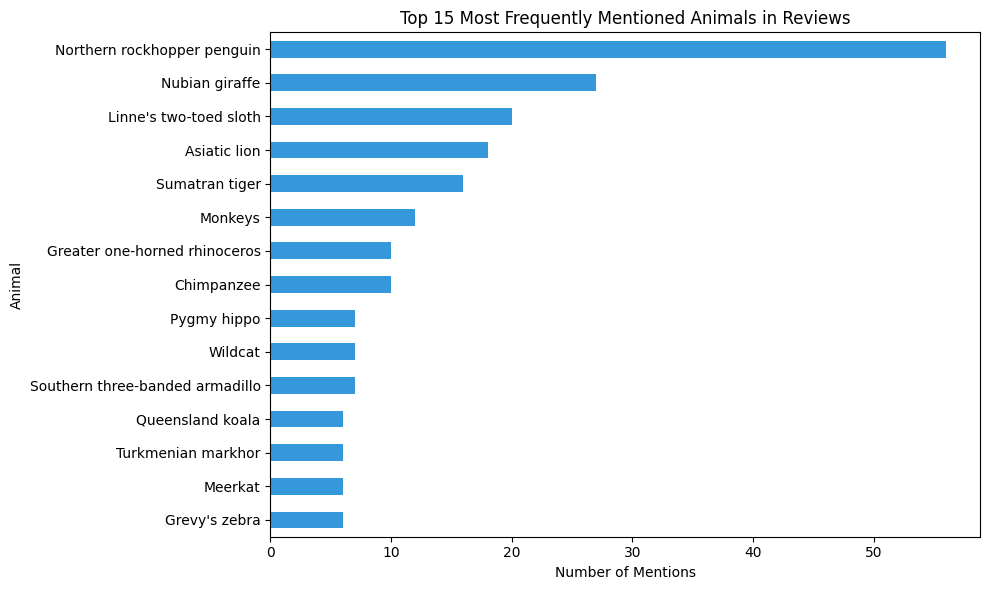

In [79]:
import matplotlib.pyplot as plt

# Count number of times each animal was mentioned (including duplicates per sentence)
mention_counts = (
    animal_sentences_df.explode("species")["species"]
    .value_counts()
    .sort_values(ascending=False)
)

# Plot top 15
mention_counts.head(15).plot(
    kind="barh",
    figsize=(10, 6),
    color="#3498db"
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Top 15 Most Frequently Mentioned Animals in Reviews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## Step 6: How Do People Feel About Each Animal?
---

Now that we know **which animals are mentioned most**, let's go one step further: we want to understand the **emotion or tone** behind each sentence.

Was the visitor...

- Excited to see the giraffes?

- Indifferent about the meerkats?

- Annoyed that the penguins weren't visible?

This process is called **sentiment analysis** — a technique that uses Natural Language Processing (NLP) to automatically detect the **emotional tone** of a sentence or phrase.

We'll apply sentiment analysis to each animal-related sentence. This will allow us to:

- Measure which animals get the most *positive* or *negative* feedback

- Spot *controversial* animals with mixed reactions

- Build visualisations to summarise how the zoo's animals are perceived overall

Let's dive in!

In [ ]:
# === Load sentiment model ===
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# === Run Sentiment Analysis on Sentences that Mention Animals ===

# Define a function to apply sentiment model to a sentence
def get_sentiment(text):
    try:
        output = sentiment_model(text)[0]
        label_map = {
            "LABEL_0": "negative",
            "LABEL_1": "neutral",
            "LABEL_2": "positive"
        }
        return pd.Series({
            "Sentiment": label_map[output["label"]],
            "Sentiment Score": output["score"]
        })
    except:
        return pd.Series({
            "Sentiment": "error",
            "Sentiment Score": 0.0
        })

# Apply sentiment analysis to animal-related sentences
animal_sentences_df[["Sentiment", "Sentiment Score"]] = animal_sentences_df["Sentence"].apply(get_sentiment)

# Preview the result
animal_sentences_df.head()

Device set to use cpu


,Review Index,Sentence,Animals Mentioned,Sentiment,Sentiment Score
0,0,It's a little bit hilly (especially on way up ...,"[Sumatran tiger, Asiatic lion]",positive,0.898857
1,3,The zoo was clean and tidy and the group loved...,"[King penguin, Gentoo penguin, Northern rockho...",positive,0.990158
2,5,Loved seeing all the different animals especia...,"[King penguin, Gentoo penguin, Nubian giraffe,...",positive,0.983468
3,6,We were lucky enough to get a good look at the...,[Linne's two-toed sloth],positive,0.919433
4,6,The penguins were great too.,"[King penguin, Gentoo penguin, Northern rockho...",positive,0.959998


#### What Did We Learn from the Sentiment Scores?

We now have a powerful dataset!
Each sentence is tagged with:

- The **animals** it mentions

- Whether it was **positive**, **neutral**, or **negative**

- A **confidence score** between 0 and 1

This sets us up for some really interesting questions:

- Which animals got the *happiest* reviews?

- Which ones triggered complaints or mixed feelings?

- How does public opinion vary between species?

To answer these, let's summarise everything visually in **Step 6**.

---
## Step 7: Visualise Animal Sentiments
---

We've now tagged each animal-related sentence with a **sentiment label** — positive, neutral, or negative — and a confidence score.

Let's bring this data to life with some visualisations!

We'll explore:

- **How often each animal was mentioned**

- **What the overall sentiment was for each one**

- **Which animals got the most praise — or criticism**

This helps us answer questions like:
> _“Which animals were the stars of the zoo?”_  
> _“Were there any surprises or mixed reviews?”_


#### Most Positively Mentioned Animals (by Count)

Let's start by looking at the **top 15 animals with the highest number of positive mentions**. These are the ones that visitors talked about most enthusiastically overall — not just because they were visible, but because they made an impression.

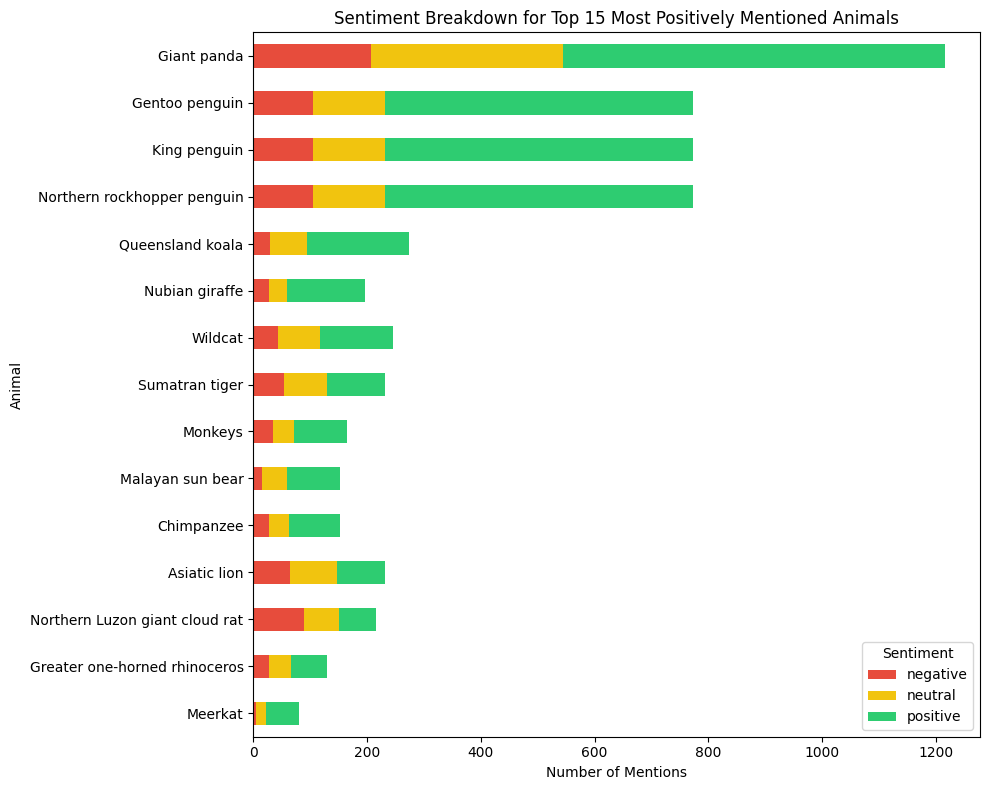

In [ ]:
import matplotlib.pyplot as plt

# Prepare a summary table: count of sentiments per animal
summary_table = (
    animal_sentences_df.explode("Animals Mentioned")
    .groupby(["Animals Mentioned", "Sentiment"])
    .size()
    .unstack(fill_value=0)
    .sort_values(by="positive", ascending=False)
)

# Plot the top 15 animals by number of positive mentions
top_animals = summary_table.head(15)

top_animals[["negative", "neutral", "positive"]].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 8),
    color=["#e74c3c", "#f1c40f", "#2ecc71"]
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Sentiment Breakdown for Top 15 Most Positively Mentioned Animals")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Most Loved Animals (by Proportion)

Sometimes, animals that aren't mentioned very often still generate **overwhelmingly positive** feedback when they are.

In this chart, we look at the **top 10 animals with the highest proportion of positive mentions** — so we can see who really impressed their fans, even if they weren't the most famous residents.

To keep things fair, we only include animals that had at least 5 total mentions. This avoids misleading results from animals that were only mentioned once — for example, a single glowing sentence might make an obscure animal seem like the most loved overall, even if no one else talked about it.

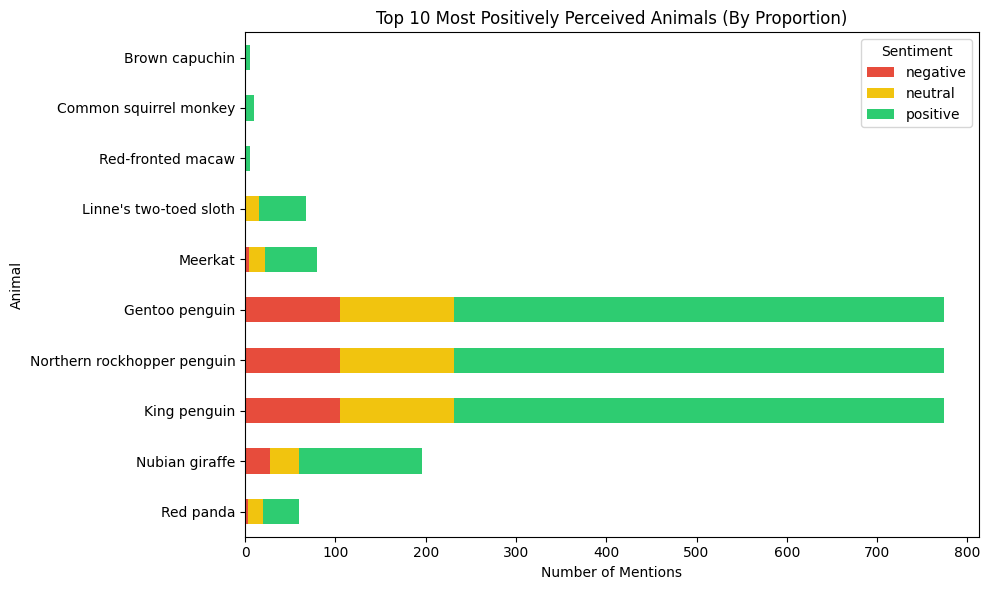

In [ ]:
# Add total mentions
summary_table["Total"] = summary_table.sum(axis=1)

# Filter for animals with at least 5 total mentions
filtered = summary_table[summary_table["Total"] >= 5].copy()

# Calculate proportion of positive mentions
filtered["Positive Proportion"] = filtered["positive"] / filtered["Total"]

# Sort by positive proportion
most_positively_perceived = filtered.sort_values("Positive Proportion", ascending=False).head(10)

# Plot
most_positively_perceived[["negative", "neutral", "positive"]].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    color=["#e74c3c", "#f1c40f", "#2ecc71"]
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Top 10 Most Positively Perceived Animals (By Proportion)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Most Criticised Animals (by Count)

Now let's flip our attention to animals that received **the most negative mentions overall**.

This helps answer questions like:

> _“Which animals did visitors complain about most?”_  
> _“Are there animals that consistently came up in negative reviews?”_

This chart shows the **top 10 animals with the highest total number of negative mentions**, regardless of how often they were praised or mentioned neutrally.

**Keep in mind:**
Animals on this list might not be universally disliked — but they may have:

- Been **hard to spot**

- Had **high expectations** attached to them

- Lived in **underwhelming enclosures**

- Or had **other issues** that disappointed visitors


Try writing the code **yourself** to generate this plot.

<div style="
  background: #e8f8f5;
  border-left: 6px solid #1abc9c;
  padding: 10px 16px;
  border-radius: 6px;
  margin-top: 12px;
  margin-bottom: 12px;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
">
  <strong>Hint:</strong>
  This task is very similar to the chart you created for <em>Most Positively Mentioned Animals (by Count)</em> — but now you'll want to <strong>sort by negative mentions</strong> instead.
</div>

In [ ]:
# Write your code here

<details style="
  background: #fef9e7;
  border-left: 6px solid #f4d03f;
  padding: 10px;
  border-radius: 8px;
  margin-top: 10px;
  margin-bottom: 12px;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
">
<summary style="font-weight: bold; cursor: pointer;">Click to see the solution if you get stuck</summary>

<div style="overflow-x: auto; padding-top: 10px;">

```python
# Sort by number of negative mentions
most_negative_by_count = summary_table.sort_values("negative", ascending=False).head(10)

# Plot
most_negative_by_count[["negative", "neutral", "positive"]].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    color=["#e74c3c", "#f1c40f", "#2ecc71"]
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Top 10 Most Criticised Animals (By Count)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
```
</details>

#### Most Criticised Animals (by Proportion)

Instead of raw counts, let's now consider **which animals received a higher share of negative feedback relative to how often they were mentioned**.

This helps surface animals that might not have been criticised the most overall — but when they were talked about, the tone wasn't great.

*We'll again limit to animals with **at least 5 total mentions**.*


Have a go at writing the code yourself!

<div style="
  background: #e8f8f5;
  border-left: 6px solid #1abc9c;
  padding: 10px 16px;
  border-radius: 6px;
  margin-top: 12px;
  margin-bottom: 12px;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
">
  <strong>Hint:</strong> Think back to how we calculated the <em>positive proportion</em> earlier — this is almost identical.<br><br>
  What needs to change is:
  <ul style="margin-top: 4px; margin-bottom: 0;">
    <li>Which column you divide by total</li>
    <li>Which column you sort by</li>
    <li>And of course, the chart title and labels</li>
  </ul>
</div>

In [ ]:
# Write your code here

<details style="
  background: #fef9e7;
  border-left: 6px solid #f4d03f;
  padding: 10px;
  border-radius: 8px;
  margin-top: 10px;
  margin-bottom: 12px;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
">
<summary style="font-weight: bold; cursor: pointer;">Click to see the solution if you get stuck</summary>

<div style="overflow-x: auto; padding-top: 10px;">

```python
# Calculate proportion of negative mentions
filtered["Negative Proportion"] = filtered["negative"] / filtered["Total"]

# Sort by negative proportion
most_negatively_perceived = filtered.sort_values("Negative Proportion", ascending=False).head(10)

# Plot
most_negatively_perceived[["negative", "neutral", "positive"]].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    color=["#e74c3c", "#f1c40f", "#2ecc71"]
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Top 10 Most Criticised Animals (By Proportion)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
```
</div>
</details>


#### Why Does This Matter?

These sentiment insights aren't just fun — they're genuinely **valuable for zoo staff and management**.

Knowing which animals people love most (and why) can help with:

- **Marketing and social media:** Showcasing crowd favourites

- **Signage and storytelling:** Adding extra info near popular enclosures

- **Experience design:** Improving visibility or engagement around less-loved animals

- **Education efforts:** Highlighting lesser-known species that people do enjoy

And when an animal consistently draws negative mentions, it might be worth investigating:

- Is the enclosure hard to access?

- Is the animal usually inactive or hidden?

- Are expectations mismatched with what visitors experience?

*In short:* this kind of data helps the zoo turn visitor feedback into **actionable insights**.

---
## Step 8: Why Do People Feel That Way?
---

We've seen which animals were mentioned most positively or negatively — both by **total number of mentions** and by **proportion of feedback**.

But so far, we've only looked at **how often** people said good or bad things.

We haven't yet explored:

> _Why do people like or dislike each animal?_  
> _What exactly are they saying about them?_

For animals with just a few mentions, we could simply read through their comments.

But what if an animal was mentioned **dozens or even hundreds of times**?

Manually reading through all those sentences, annotating what people liked or disliked, and trying to summarise it would take **a very long time** — especially if we’re doing this for multiple animals.

We'd need to:

- Read and understand each sentence

- Categorise or tag each opinion

- Look for common themes

- Then write a summary ourselves

That's **slow**, **repetitive**, and prone to **human error or bias**.

This is exactly where **language models** shine. They can process large amounts of text and generate a summary that captures the **core themes and sentiments**, giving us a quick but meaningful overview of what people are saying.

Let's see how that works in Step 8!

---
## Step 9: Summarise Visitor Opinions with a Language Model
---

Let's now use a **Large Language Model (LLM)** to help us make sense of what visitors actually said about each animal.

Instead of reading through every sentence ourselves, we'll ask the model to:

- Understand the full set of comments for one animal

- Identify common themes and sentiments

- Generate a short, natural-language summary

This gives us a **quick and readable overview** — especially useful when we have dozens (or hundreds!) of mentions.

#### What's a Language Model (LLM)?

A **Language Model** is a type of artificial intelligence (AI) trained to understand and generate human language.

- It has read **huge amounts of text** — like books, articles, and online conversations.

- It has learned the **patterns of language** — how ideas connect, what words tend to go together, and what kinds of answers people expect.

- You can give it a **prompt** (like “Summarise these sentences”) — and it will try to respond like a human would.

When a Language Model is trained on billions of words and has billions of parameters (internal weights), we call it a **Large Language Model**, or **LLM**.

Famous examples include:

- ChatGPT

- Claude

- Mistral

- LLaMA

- Gemini

#### How Will We Use It?

We'll ask the LLM to **read all the visitor comments** about a specific animal and **generate a short summary**.

This will help us quickly uncover:

- Common reasons why people liked it

- Typical issues or disappointments

- Patterns in the feedback (e.g., excitement, boredom, confusion)

This is **especially helpful** when:

- There are **dozens or hundreds** of mentions

- You want to **save time** and avoid reading everything manually

- You need to make **decisions** about animal care, signage, or marketing


#### How Does It Actually Work?

1. We collect all the sentences where an animal was mentioned.

2. We create a **prompt** like:
   > “Summarise what zoo visitors say about the penguin. Include common opinions, emotions, and experiences.”

3. We feed the prompt and sentences into the LLM.

4. The LLM generates a natural-language summary — just like a human might write.

The result is a quick and human-readable **snapshot** of public opinion.


#### Example Output

Here's what it might look like when we summarise two animals:

<div style="
  background: #eaf2f8;
  border-left: 6px solid #3498db;
  padding: 14px 16px;
  border-radius: 6px;
  margin-top: 16px;
  margin-bottom: 14px;
  max-width: 100%;
  overflow-wrap: break-word;
  box-sizing: border-box;
">
  <p style="margin: 0; font-size: 14px;"><strong>🐧 penguin</strong><br>
  <em>→ Visitors frequently mentioned how playful and active the penguins were, especially when swimming. Some also noted they were fun to watch with kids. A few comments mentioned difficulty seeing them during warmer weather.</em></p>

  <br>

  <p style="margin: 0; font-size: 14px;"><strong>🦒 giraffe</strong><br>
  <em>→ People often described the giraffes as majestic and gentle. Many reviews praised how close visitors could get to them, though some noted long queues near the enclosure.</em></p>
</div>


Let's build this together in the next cells!

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# Load local model (this will need to be adjusted based on the local setup)
model_path = "/Users/arturmiralles/mistral_models/7B-Instruct-v0.3"

llm_tokenizer = AutoTokenizer.from_pretrained(model_path)
llm_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
).to("cuda" if torch.cuda.is_available() else "cpu")

llm_pipeline = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=llm_tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    pad_token_id=llm_tokenizer.eos_token_id
)

In [ ]:
from IPython.display import display, HTML

# Set animals to summarise
ANIMALS_TO_SUMMARISE = ["Red panda"]  # change or extend this list as needed
MAX_CHAR_PER_PROMPT = 2000  # safeguard for long inputs

# Use this as your sentence-level DataFrame
sentence_df = animal_sentences_df  # or rename earlier if preferred

# Dictionary to store summaries
animal_summaries = {}

for animal in ANIMALS_TO_SUMMARISE:
    # Step 1: Mention filter with robust matching
    animal_sentences = sentence_df[
        sentence_df["Animals Mentioned"].apply(
            lambda x: any(animal.lower() == a.strip().lower() for a in x)
        )
    ]

    # Step 2: Keep only opinionated sentences
    animal_sentences = animal_sentences[
        animal_sentences["Sentiment"].isin(["positive", "negative"])
    ]

    if animal_sentences.empty:
        animal_summaries[animal] = "(No comments found for this animal.)"
        continue

    # Combine sentences into one string (truncated if too long)
    text_block = " ".join(animal_sentences["Sentence"].tolist())[:MAX_CHAR_PER_PROMPT]

    # Create LLM prompt
    prompt = (
        f"You are a helpful assistant that summarises visitor opinions about zoo animals.\n\n"
        f"Below is a collection of review sentences that mention the {animal}. "
        f"Summarise what people said specifically about the {animal} — include common opinions, emotional reactions, and noteworthy experiences.\n\n"
        f"Do not mention other animals or general zoo facilities. Only refer to the {animal}.\n\n"
        f"Visitor comments:\n{text_block}\n\n"
        f"Summary about the {animal}:"
    )

    try:
        response = llm_pipeline(
            prompt,
            max_new_tokens=300,
            do_sample=False,
            truncation=True
        )[0]["generated_text"]

        # Extract just the summary part
        summary = response.split(f"Summary about the {animal}:")[-1].strip()
    except Exception as e:
        summary = f"(Error: {e})"

    animal_summaries[animal] = summary

# Display results with styling
for animal, summary in animal_summaries.items():
    display(HTML(f"""
        <div style="
            background: #eaf2f8;
            border-left: 6px solid #3498db;
            padding: 14px 16px;
            border-radius: 6px;
            margin-top: 16px;
            margin-bottom: 14px;
            max-width: 100%;
            overflow-wrap: break-word;
            box-sizing: border-box;
        ">
            <p style="margin: 0; font-size: 14px;">
                <strong>🐾 {animal.capitalize()}</strong><br>
                <em> {summary}</em>
            </p>
        </div>
    """))

---
## Bonus Task: Experiment, Reflect, and Recommend
---

Now that you've seen how a **Large Language Model (LLM)** can summarise visitor opinions, it's your turn to explore further!

#### Play Around with the Prompt

Can you get different types of summaries?

- Try rewording the `prompt`:
  - “Write a fun, informal review of what people think about the *animal*.”
  - “List three common complaints people have about the *animal*'s enclosure.”

- Make it more detailed, playful, or emotional — and see how the tone changes!

#### Try Different Animals

Change the `ANIMALS_TO_SUMMARISE` list to explore other animals.

- Which animals have the most enthusiastic visitors?

- Which get mixed or negative reactions?

In [ ]:
# Write your code here

---
## Final Reflection: Zoo Designers Wanted!
---

Imagine you work at the zoo and your job is to improve the visitor experience.

Based on what you've read or summarised:

- What patterns did you notice?

- Which animals were most loved? Why?

- Were there any recurring issues people had?

Write down 1-2 ideas you would suggest to the zoo:

- It could be an improvement for one animal's enclosure

- Or a new idea for signage, events, or volunteer guides

Be creative — you're using data to make real-world decisions!